## ZTF DR7 matchfiles to SDSS : offsets NEW (2022 Oct)

In [1]:
%load_ext autoreload
%autoreload 2

## Connect to Spark 

In [10]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .config('spark.master', "local[20]") # 20 when running the full crossmatch, 10 when doing validation.
         .config('spark.driver.memory', '80G')
         .config("spark.sql.execution.arrow.enabled", "true")
         # uncomment if beta-jupyterhub proxies are working again.  otherwise, tunnel
         #.config("spark.ui.proxyBase", "https://epyc.astro.washington.edu/beta-jupyter/user/ecbellm/proxy/4040")
         .config("spark.port.maxRetries", "128")
         .enableHiveSupport()
         .getOrCreate())

## Crossmatch SDSS standard stars to ZTF ... 

Use the most recent catalog (v4.2) telling us which objects are standard stars 
https://faculty.washington.edu/ivezic/sdss/catalogs/stripe82.html


In [1]:
url = 'https://faculty.washington.edu/ivezic/sdss/calib82/dataV2/stripe82calibStars_v4.2.dat'

In [2]:
pwd

'/data/epyc/users/suberlak'

In [3]:
import os
path = os.getcwd()
os.system(f'wget {url}')   

0

Read-in the standard stars catalog. 

In [12]:
colnames = ['col1', 'RA','Dec','RArms','Decrms','Ntot','Ar', 
            'uNobs','umed', 'ummu', 'umsig', 'umrms', 'umchi2',
            'gNobs','gmed', 'gmmu', 'gmsig', 'gmrms', 'gmchi2',
            'rNobs','rmed', 'rmmu', 'rmsig', 'rmrms', 'rmchi2',
            'iNobs','imed', 'immu', 'imsig', 'imrms', 'imchi2',
            'zNobs','zmed', 'zmmu', 'zmsig', 'zmrms', 'zmchi2'] 

In [8]:
from astropy.table import Table
fname = 'stripe82calibStars_v4.2.dat'

stars = Table.read(fname, format='ascii',
                   names = colnames
            )

In [14]:
stars[:2]

col1,RA,Dec,RArms,Decrms,Ntot,Ar,uNobs,umed,ummu,umsig,umrms,umchi2,gNobs,gmed,gmmu,gmsig,gmrms,gmchi2,rNobs,rmed,rmmu,rmsig,rmrms,rmchi2,iNobs,imed,immu,imsig,imrms,imchi2,zNobs,zmed,zmmu,zmsig,zmrms,zmchi2
str18,float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
CALIBSTARS_0000001,308.500219,-1.227713,0.0227,0.0227,7,0.587,3,23.87,23.823,0.611,0.06,0.056,6,22.388,22.269,0.05,0.154,1.554,7,20.832,20.834,0.017,0.056,1.05,7,20.168,20.202,0.015,0.046,1.105,7,19.9,19.818,0.04,0.116,1.212
CALIBSTARS_0000002,308.500072,-1.240266,0.0141,0.0141,7,0.596,4,21.97,21.966,0.093,0.045,0.225,7,20.488,20.462,0.014,0.042,1.116,7,19.763,19.768,0.011,0.052,0.299,7,19.532,19.504,0.013,0.032,0.808,7,19.439,19.386,0.034,0.095,0.824


Next steps:
    
    * the AXS `sdss` table of stars is huge . Need to sub-select only those objects that are in the standard stars table (i.e. from 500 mln to ~1mln objects).
    
    * can I cross-match an AXS table against eg. astropy table? Or does the astropy table need to be saved first as an AXS table? I think I know how to do that for a relatively small table like standard stars, because it's exactly like what I did for the DBQSO table...
    
    
    * then once I've cross-matched `stripe82calibStars_v4.2`  against the `sdss` table, I can check how many of these have also have the ZTF data.  - that way I'm using ZTF data only for the standard stars that have been very well measured
    
    * if there aren't enough ZTF objects in that crossmatch,  can widen the search by starting from sdss table, selecting on magnitude, etc, and crossmatch against ZTF, but also limiting to choose the most-observed objects. That way we'll minimize the impact of error (although there still will be some variable stars there since I don't have an all-sky standard stars catalog).
    
    

## Make AXS table from stripe82calibStars

In [11]:
from axs.catalog import AxsCatalog
from axs.axsframe import AxsFrame
axs_catalog = AxsCatalog(spark)

In [16]:
from pyspark.sql.types import *
# make pandas df 
df = stars.to_pandas()

# rename columns
df.rename(columns = {'RA':'ra', 'Dec':'dec'}, inplace = True)


col1,RA,Dec,RArms,Decrms,Ntot,Ar,uNobs,umed,ummu,umsig,umrms,umchi2,gNobs,gmed,gmmu,gmsig,gmrms,gmchi2,rNobs,rmed,rmmu,rmsig,rmrms,rmchi2,iNobs,imed,immu,imsig,imrms,imchi2,zNobs,zmed,zmmu,zmsig,zmrms,zmchi2
str18,float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
CALIBSTARS_0000001,308.500219,-1.227713,0.0227,0.0227,7,0.587,3,23.87,23.823,0.611,0.06,0.056,6,22.388,22.269,0.05,0.154,1.554,7,20.832,20.834,0.017,0.056,1.05,7,20.168,20.202,0.015,0.046,1.105,7,19.9,19.818,0.04,0.116,1.212
CALIBSTARS_0000002,308.500072,-1.240266,0.0141,0.0141,7,0.596,4,21.97,21.966,0.093,0.045,0.225,7,20.488,20.462,0.014,0.042,1.116,7,19.763,19.768,0.011,0.052,0.299,7,19.532,19.504,0.013,0.032,0.808,7,19.439,19.386,0.034,0.095,0.824


In [31]:
# make spark df 
fields = list(df.columns) 

#[ col1 RA Dec RArms Decrms 
#Ntot  Ar 
#uNobs  umed ummu umrms  umchi2 
#g ..
#r .. 
#i .. 
#z .. ] 

field_types = [StringType(),DoubleType(),DoubleType(),DoubleType(),DoubleType(),
               IntegerType(),DoubleType(),
               IntegerType(), DoubleType(),DoubleType(),DoubleType(),DoubleType(),DoubleType(),
               IntegerType(), DoubleType(),DoubleType(),DoubleType(),DoubleType(),DoubleType(),
               IntegerType(), DoubleType(),DoubleType(),DoubleType(),DoubleType(),DoubleType(),
               IntegerType(), DoubleType(),DoubleType(),DoubleType(),DoubleType(),DoubleType(),
               IntegerType(), DoubleType(),DoubleType(),DoubleType(),DoubleType(),DoubleType(),
               ]

fields = [StructField(field_name, type_class, True) for field_name, 
          type_class in zip(fields, field_types)]
schema = StructType(fields)
sdf = spark.createDataFrame(df,schema=schema)

In [33]:
from axs import Constants
axs_catalog.save_axs_table(sdf,"stripe82calibStars_v42",  True, True, 500 ,Constants.ONE_AMIN)

In [35]:
axs_catalog.list_table_names()

['gaia_dr2_1am_dup',
 'allwise_1am_dup',
 'unwise_v1',
 'cklein_flare',
 'unwise_v2',
 'catalina_variables_n',
 'gaia',
 'gaia_dr2_1am_dup_ssd',
 'ps1',
 'green19_stellar_params',
 'rosat_2rxs',
 'rosat_2rxs_z4am_b2am',
 'ztf_dr3_2rxs_obj',
 'wtf_ztf_dr3',
 'ztf_wds_kjb_dr3',
 'karenws_cut_wtf_fits_r_band',
 'karenws_cut_wtf_fits',
 'ztf_aug2020_2rxs_obj',
 'skymapper_dr2',
 'test_skymapper',
 'skymapper_dr2_ver2',
 'skymapper_dr2_ver3',
 'ztf_rrlyr',
 'gaia_source_edr3',
 'gaia_edr3_distances',
 'rrlyrae_sample_andy',
 'stevengs_test_small_df',
 'ztf5',
 'feh_rrlyr_ab_020620',
 'kepler_rrlyrae',
 'ztf_kepler_rrlyrae',
 'ps_uband',
 'ps_uband_ver2',
 'debug_match_a',
 'debug_match_b',
 'debug_match_c',
 'ztf_rrlyr_grid_50',
 'igaps_halpha_emitters',
 'wtf_aug2020_asymmetric_2',
 'wtf_aug2020_asymmetric_3',
 'wtf_aug2020_dip_candidates',
 'ztf_rr_lyrae_preprocessed_and_gridded_09_01_2021',
 'ztf_rr_lyrae_phi_31_fits_09_01_2021',
 'stevengs_test_sources',
 'ddf_sources_bigger',
 'ztf_dr7

Yes, it's there! So now lets cross-match that against the ZTF and see how many we have got 

In [36]:
s82 = axs_catalog.load('stripe82calibstars_v42')

In [37]:
s82.head(1)

[Row(col1='CALIBSTARS_0671764', ra=0.005209, dec=-1.067087, RArms=0.0305, Decrms=0.0305, Ntot=14, Ar=0.106, uNobs=13, umed=21.403, ummu=21.409, umsig=0.03, umrms=0.092, umchi2=1.011, gNobs=14, gmed=20.5, gmmu=20.499, gmsig=0.009, gmrms=0.046, gmchi2=1.544, rNobs=13, rmed=20.185, rmmu=20.182, rmsig=0.008, rmrms=0.017, rmchi2=0.62, iNobs=14, imed=20.067, immu=20.061, imsig=0.009, imrms=0.04, imchi2=1.076, zNobs=14, zmed=19.996, zmmu=20.003, zmsig=0.029, zmrms=0.136, zmchi2=1.197, zone=5335, dup=0)]

We know that S82 stars cover a limited range in ra,dec :

Text(0, 0.5, 'dec')

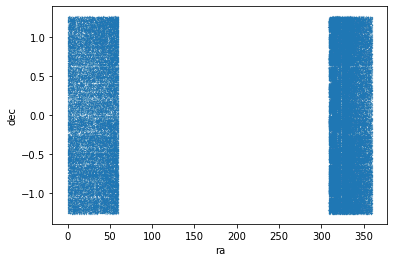

In [47]:
# it's a narrow strip in dec 
# select just the brightest stars for illustration
table = s82.select(['ra','dec']).where(s82['gmed']<18).toPandas()

%matplotlib inline
import matplotlib.pyplot as plt 
plt.scatter(table['ra'], table['dec'], s=0.01)
plt.xlabel('ra')
plt.ylabel('dec')

In [62]:
m = table['ra'] < 200
max(table['ra'][m])

59.998112

In [63]:
m = table['ra'] > 200
min(table['ra'][m])

308.500101

Therefore to speed up the crossmatch process, we limit the range of ZTF to dec covered by S82 : $\|{ \delta }\| < 1.3$. Also,  select ZTF light curves that have more than N  good measurementsm

In [49]:
ztf = axs_catalog.load('ztf_dr7')

In [51]:
ztf.head(1)

[Row(ps1_objid=88490000075421199, ra=0.0076964998152107, dec=-16.257665634155273, ps1_gMeanPSFMag=-999.0, ps1_rMeanPSFMag=21.7761, ps1_iMeanPSFMag=21.483801, ra_detections=[0.007681999821215868, 0.007710999809205532], dec_detections=[-16.257688522338867, -16.25764274597168], mjd_g=[58351.4296875, 58677.46484375], mag_g=[21.829124450683594, 21.65118980407715], magerr_g=[0.2586859464645386, 0.2459336519241333], catflags_g=[0, 0], rcID_g=[42, 42], fieldID_g=[294, 294], mjd_r=[58348.421875, 58365.3828125, 58370.40234375, 58374.34375, 58674.48828125, 58778.3203125, 59053.4609375], mag_r=[21.415929794311523, 21.341657638549805, 21.397357940673828, 21.187511444091797, 20.80579376220703, 19.94454002380371, 21.422996520996094], magerr_r=[0.23385584354400635, 0.22855126857757568, 0.2325294017791748, 0.21754217147827148, 0.19027996063232422, 0.1290365308523178, 0.2343604564666748], catflags_r=[0, 0, 0, 0, 0, 0, 0], rcID_r=[42, 42, 42, 42, 42, 42, 42], fieldID_r=[294, 294, 294, 294, 294, 294, 294]

In [64]:
# need to use the spark abs to limit on declination 
from pyspark.sql.functions import abs as sparkabs  

# since I need mostly r-band offsets,
# select on r_band
fid = 'r'

# note = zone and dup are needed for the crossmatch
ztf_sub = ztf.select(['zone', 'dup', 'ps1_objid', 'ra','dec', 'ps1_gMeanPSFMag', 
                      'ps1_rMeanPSFMag','ps1_iMeanPSFMag',
           'nobs_g','nobs_r','nobs_i',
           'mean_mag_g','mean_mag_r','mean_mag_i',
           'magerr_g','magerr_r','magerr_i']).\
          where((ztf[f'nobs_{fid}']>1) & (sparkabs(ztf['dec']) < 1.3) & \
               ((ztf['ra'] < 61 ) | (ztf['ra'] > 305))
               )


# note  - originally the selection in ra was not there - 
# resulting in 35,655,973 objects

# adding the ra selection gives 5,833,530
# so it's significantly less 

# 

In [65]:
%%time 
ztf_sub.count()

CPU times: user 16.1 ms, sys: 10.8 ms, total: 26.8 ms
Wall time: 1min 23s


5833530

In [57]:
%%time 
ztf_sub.count()

CPU times: user 23.2 ms, sys: 11.8 ms, total: 34.9 ms
Wall time: 1min 44s


35655973

Text(0, 0.5, 'dec')

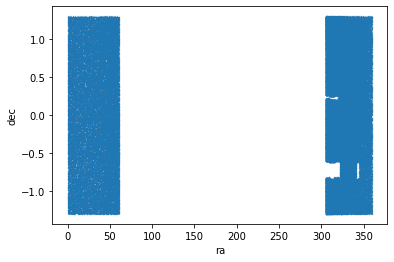

In [67]:
# select a small subset of ztf and plot 
table = ztf_sub.select(['ra','dec']).where(ztf_sub['mean_mag_g']<18).toPandas()
plt.scatter(table['ra'], table['dec'], s=0.01)
plt.xlabel('ra')
plt.ylabel('dec')

In [68]:
# this is only for the bright stars plotted above
len(table)

348070

ok, this shows that there are  ZTF observations of stars in S82 (with some missing coverage). Let's do the crossmatch:

In [70]:
#axs_catalog.drop_table('s82stars_ztf')

In [71]:
%%time

# crossmatching the 1 mln s82 stars against 5mln of  ZTF objects there 
# I'm sure there'll be enough do calculate updated offsets
from axs import Constants
fname = "s82stars_ztf"
crossmatch = s82.crossmatch(ztf_sub, r=2*Constants.ONE_ASEC).\
    save_axs_table(fname)

CPU times: user 87.1 ms, sys: 48.7 ms, total: 136 ms
Wall time: 6min 9s


In [ ]:
# the above seems to take ~40g of RES (physical memory) 
# so setting spark.driver.memory  to 80G seems a sufficient choice 



## ZTF - SDSS offsets with s82 calib stars 

This is better than before because we have pristine v4.2 catalog which used more epochs for stars, thus the measurement is more accurate. 

In [1]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .config('spark.master', "local[10]") # 20 when running the full crossmatch, 10 when doing validation.
         .config('spark.driver.memory', '80G')
         .config("spark.sql.execution.arrow.enabled", "true")
         # uncomment if beta-jupyterhub proxies are working again.  otherwise, tunnel
         #.config("spark.ui.proxyBase", "https://epyc.astro.washington.edu/beta-jupyter/user/ecbellm/proxy/4040")
         .config("spark.port.maxRetries", "128")
         .enableHiveSupport()
         .getOrCreate())

In [2]:
from axs.catalog import AxsCatalog
axs_catalog = AxsCatalog(spark)

In [3]:
fname = 's82stars_ztf'
s82_ztf = axs_catalog.load(fname)

In [113]:
np.ravel(s82_ztf.columns)

array(['col1', 'RArms', 'Decrms', 'Ntot', 'Ar', 'uNobs', 'umed', 'ummu',
       'umsig', 'umrms', 'umchi2', 'gNobs', 'gmed', 'gmmu', 'gmsig',
       'gmrms', 'gmchi2', 'rNobs', 'rmed', 'rmmu', 'rmsig', 'rmrms',
       'rmchi2', 'iNobs', 'imed', 'immu', 'imsig', 'imrms', 'imchi2',
       'zNobs', 'zmed', 'zmmu', 'zmsig', 'zmrms', 'zmchi2', 'dup', 'dup2',
       'ps1_objid', 'ps1_gMeanPSFMag', 'ps1_rMeanPSFMag',
       'ps1_iMeanPSFMag', 'nobs_g', 'nobs_r', 'nobs_i', 'mean_mag_g',
       'mean_mag_r', 'mean_mag_i', 'magerr_g', 'magerr_r', 'magerr_i',
       'axsdist', 'ra', 'dec', 'zone'], dtype='<U15')

ok, so we have the crossmatch! Let's make r-band offsets (of course other bands could be done with this data too, but it was selected with at least 1 obsetvation in the r-band...)

One thing is that we don't have an aggregate column with median ZTF error. Need to make it from `magerr_g` array columns... 

In [94]:
# from pyspark.sql.functions import udf
# from pyspark.sql.types import FloatType
# import numpy as np 
# array_mean = udf(lambda x: float(np.mean(x)), FloatType())
# mean_g = s82_ztf.select(array_mean("magerr_g").alias("mean_magerr_g"))

In [42]:
# add_column has syntax 
#  https://axs.readthedocs.io/en/latest/_modules/axs/axsframe.html
# colname : name of new column
# coltype : column type, string parsed to pyspark.sql.types._parse_datatype_string
# func: a function applied to the dataframe row by row 
# col_names : column names (or a single name) of columns to apply that function to 
for fid in 'gri':
    s82_ztf = s82_ztf.add_column(f'mean_magerr_{fid}', 
                   'float',
                   lambda x: float(np.median(x)), 
                   f'magerr_{fid}')
                   

In [43]:
np.ravel(s82_ztf.columns)

array(['col1', 'RArms', 'Decrms', 'Ntot', 'Ar', 'uNobs', 'umed', 'ummu',
       'umsig', 'umrms', 'umchi2', 'gNobs', 'gmed', 'gmmu', 'gmsig',
       'gmrms', 'gmchi2', 'rNobs', 'rmed', 'rmmu', 'rmsig', 'rmrms',
       'rmchi2', 'iNobs', 'imed', 'immu', 'imsig', 'imrms', 'imchi2',
       'zNobs', 'zmed', 'zmmu', 'zmsig', 'zmrms', 'zmchi2', 'dup', 'dup2',
       'ps1_objid', 'ps1_gMeanPSFMag', 'ps1_rMeanPSFMag',
       'ps1_iMeanPSFMag', 'nobs_g', 'nobs_r', 'nobs_i', 'mean_mag_g',
       'mean_mag_r', 'mean_mag_i', 'magerr_g', 'magerr_r', 'magerr_i',
       'axsdist', 'ra', 'dec', 'zone', 'mean_magerr_g', 'mean_magerr_r',
       'mean_magerr_i'], dtype='<U15')

In [45]:
%%time
s82_ztf.count()

937701

In [76]:
df = s82_ztf.select(['umed', 'ummu',
       'umsig', 'umrms', 'umchi2', 'gNobs', 'gmed', 'gmmu', 'gmsig',
       'gmrms', 'gmchi2', 'rNobs', 'rmed', 'rmmu', 'rmsig', 'rmrms',
       'rmchi2', 'iNobs', 'imed', 'immu', 'imsig', 'imrms', 'imchi2',
       'zNobs', 'zmed', 'zmmu', 'zmsig', 'zmrms', 'zmchi2']).limit(2000).toPandas()

In [77]:
df

,umed,ummu,umsig,umrms,umchi2,gNobs,gmed,gmmu,gmsig,gmrms,...,immu,imsig,imrms,imchi2,zNobs,zmed,zmmu,zmsig,zmrms,zmchi2
0,21.403,21.409,0.030,0.092,1.011,14,20.500,20.499,0.009,0.046,...,20.061,0.009,0.040,1.076,14,19.996,20.003,0.029,0.136,1.197
1,20.861,20.871,0.021,0.070,0.899,14,18.438,18.433,0.005,0.020,...,16.857,0.004,0.007,0.495,14,16.596,16.597,0.005,0.013,0.657
2,17.836,17.836,0.005,0.023,0.996,14,16.778,16.780,0.005,0.018,...,16.212,0.004,0.006,0.336,14,16.161,16.158,0.005,0.016,0.848
3,23.327,23.366,0.221,0.072,0.122,13,21.681,21.675,0.018,0.049,...,18.957,0.006,0.009,0.406,14,18.255,18.256,0.008,0.042,1.232
4,19.213,19.219,0.008,0.034,1.120,13,16.999,17.001,0.005,0.009,...,15.771,0.004,0.012,0.730,14,15.607,15.606,0.005,0.018,1.031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,24.161,24.094,0.347,0.271,0.236,14,22.903,22.812,0.054,0.247,...,20.087,0.010,0.027,0.742,18,19.484,19.471,0.017,0.055,0.642
1996,24.461,24.507,0.388,0.200,0.196,15,22.476,22.431,0.031,0.093,...,19.149,0.005,0.015,0.724,18,18.267,18.274,0.007,0.036,1.254
1997,24.185,24.145,0.407,0.090,0.107,18,21.943,21.957,0.020,0.121,...,19.542,0.006,0.020,0.722,17,19.013,19.026,0.012,0.069,1.367
1998,24.769,24.799,0.529,0.057,0.051,13,22.940,22.911,0.053,0.185,...,19.488,0.006,0.021,0.844,18,18.681,18.676,0.009,0.041,1.117


In [121]:
# given the table description
# https://faculty.washington.edu/ivezic/sdss/catalogs/stripe82.html

# Let's use ummu  : the mean value 
# and  aa measure of uncertainty umsig,  
# which is standard error for the mean 

# the other option would be to use 
# umed : the median value, and the 
#1.25*umsig 

Now we have all we need to calculate offsets. 

In [87]:
from astropy.table import Table
def find_offset_sdss_survey(axs_catalog, originband = 'g',
                            targetband = 'r', sdsscolors = 'gi',
                            magCol = 'mmu',  survey = 'ZTF', degree = 1 , 
                            xlims = [-0.5,2.5],
                            ylims = [-0.2, 1.5], Nmin = 10, 
                            nsources = 10000,
                            xfitlims = [0.25, 1.5], 
                            save=False, 
                            rlim=20) :
    '''
    Find photometric offsets between SDSS and a survey, like
    ZTF, one band at a time. 
   
    data :  a table containing ugri SDSS photometry, cross-matched to 
            the target survey, eg. SDSS-ZTF
           
    originband : band present in the origin survey. Eg., 
               for ZTF it's 'g', 'r' or 'i'
               
    targetband : synthetic SDSS band to which we transform the ZTF band, 
               eg. 'r'.  One could have ZTF(gri) --> SDSS(rrr),  
               or  ZTF(gri) --> SDSS(gri)   , depending on the need 
    
    sdsscolors : SDSS colors used to spread the stellar locus.  It can be 
           "gr" or "gi" (this mainly affects the x-axis limits). 
           'gi' is preferred as default because it provides a larger
            wavelength baseline 
           
    magCol : the name of column in 'data' that contains the 
            survey magnitudes
    
    errCol : the name of column in 'data' that contains the 
            survey magnitude error
            
    survey : the name of the survey . Here by default it is 'ZTF' 
    
    degreee : the degree of fitted polynomial to derive photometric 
            offsets.  '1' is the default. The fitted polynomial 
            is overplotted with a red line over the stellar locus. 
            The fitted points are weighted by their errors. 
            
    xlims : limits on the x-axis in magnitudes (depends on the 
          SDSS color chosen for the x-axis). By default, [-0.5,2.5]
         
    ylims : limits on the y-axis in magnitudes (depends on 
        the origin and target bands and relative offsets). 
        By default,  [-0.2, 1.5]
        
    nsources: how many sources to take from the input spark tables?  
         The default is 10000, which is enough to quickly execute, 
         see the stellar locus, fine-tune the parameters of fit, 
         xlims, ylims of the plot, etc. 
         More may be desired for better statistics,  but it has to be 
         less than the total length of the table (!)
    xFITlims : the limits along x-axis (SDSS color) for points used for the 
         polynomial fit. By default,  for (g-i) its [0.25, 1.5] and for 
         (g-r) its [0.1, 1.1]
    '''
   
   

    # convert the axs_catalog given to Pandas dataframe 
    data = axs_catalog.select(['nobs_g', 'nobs_r', 'nobs_i', 
                               'mean_magerr_g', 'mean_magerr_r', 'mean_magerr_i',
                               'mean_mag_g', 'mean_mag_r', 'mean_mag_i',     
                           'Ntot', 'Ar', 'uNobs', 'umed', 'ummu',
       'umsig', 'umrms', 'umchi2', 'gNobs', 'gmed', 'gmmu', 'gmsig',
       'gmrms', 'gmchi2', 'rNobs', 'rmed', 'rmmu', 'rmsig', 'rmrms',
       'rmchi2', 'iNobs', 'imed', 'immu', 'imsig', 'imrms', 'imchi2',
       'zNobs', 'zmed', 'zmmu', 'zmsig', 'zmrms', 'zmchi2', 
       'ps1_objid', 'ps1_gMeanPSFMag', 'ps1_rMeanPSFMag',
       'ps1_iMeanPSFMag',]).\
    limit(nsources).toPandas()

    
    # define aliases for SDSS mags  
    errCol = 'msig'
        
    gmag = data[f'g{magCol}']
    rmag = data[f'r{magCol}']
    imag = data[f'i{magCol}']


    #xaxis : SDSS color  - 'gi' or 'gr'
    if sdsscolors is 'gr': 
        x = gmag-rmag 

    if sdsscolors is 'gi' : 
        x = gmag-imag  
        
    # create the plotting space 
    fig,axs = plt.subplots(1,1, figsize=(5, 4.8), dpi=100)
    ax = np.ravel(axs)
    i = 0 

    # make a table to store coefficients derived from this set of data 
    if degree == 1 : 
        coeffs  = {'x' : [], 'y' : [], 'B_0' : [], 'B_1':[]}

    if degree == 2 : 
        coeffs  = {'x' : [], 'y' : [], 'A_0' : [], 'A_1':[],'A_2':[]}

     # no need to loop since we're doing one filter at a time 
    # the SDSS target is 'r' only . since that's the "master band"
    f1,f2  = originband, targetband
    print(' ')
    print('y = f1 - f2 = f(x)')
    print('f2 = f1 - f(x)')

    # store filters used 
    coeffs['x'].append('('+sdsscolors[0]+'-'+sdsscolors[1]+')_SDSS')
    coeffs['y'].append(f1 +survey+'-'+f2+'SDSS')

    # remove objects without ZTF obs ...
    print('Starting with ', len(data), ' objects ')
    m1 = data[f'nobs_{f1}'] > Nmin 
    print(f'\nRemoving objects where nobs_{f1} < {Nmin} ')
    print('= Left with ', np.sum(m1), ' objects')
    
    # remove faint objects...
    print(f'\nAlso removing faint objects where SDSS r >{rlim}')
    m2 =  rmag<rlim
    print(f'= Left with  {np.sum(m2)} objects')
          
    m = m1*m2
    print(f'\n In total left with {np.sum(m)}')
    
    
    surveyMag = data[f'mean_mag_{f1}']  # that's for ZTF 
    sdssMag  = data[f'{f2}{magCol}']

    y  = surveyMag - sdssMag

    # combine errors in quadrature to use as weights in 
    # fitting with polynomial 
    e1 = data[f'mean_magerr_{f1}'] # Survey error 
    e2 = data[f'{f2}{errCol}']  # SDSS chosen error
    
    # remove stars that have no obs in that filter 
    ax[i].hexbin(x[m],y[m], extent= (xlims[0],xlims[1], 
                                       ylims[0], ylims[1]), bins='log'
                     )

    
    # make the linear fits 
    m3 = (xfitlims[0]<x) & (x<xfitlims[1]) # within the xlims of the fit 
    m4 = (ylims[0] < y) & (y < ylims[1]) # within the ylims of the plot 
    m5 = np.bitwise_not(np.isnan(e1)) # points that do not have the error for ZTF 
    m_ = m1 & m2 & m3 & m4 & m5
    
    
    print('\nOf these we do not use for fitting those  beyond the limits of the \
    plot, or xlims of fitted region.')
    print('=Left with ', np.sum(m_),' objects used for fitting')
    

    # fit n-th degree polynomial
    xf  = x[m_] ;  yf=y[m_] ; ef = np.sqrt(e1[m_]**2.0 + e2[m_]**2.0)

    p = np.polyfit(xf,yf,deg=degree)#, w=1/ef)

    if degree == 1 : 
        # like  y = B_0 + B_1 * x as  in Tonry+2012 
        coeffs['B_1'].append(p[0]) 
        coeffs['B_0'].append(p[1])  
        x_ = np.linspace(xfitlims[0],xfitlims[1], 100)
        ax[i].plot(x_, p[0] *x_ + p[1]  , c='red')
        print('y = f(x) = B0 + B1*x')
        print('')
        
        
        print(f2,'_SDSS_synth =', f1,'_', survey,'- (', str(coeffs['B_0'][0])[:5],
             ')-(',str(coeffs['B_1'][0])[:5],')*','SDSS', 
              '(',sdsscolors[0],'-',sdsscolors[1],')')
        print('')

    if degree == 2 : 
        # like  y = A_0 + A_1 * x  + A_2*x*x in Tonry+2012 
        coeffs['A_2'].append(p[0]) 
        coeffs['A_1'].append(p[1]) 
        coeffs['A_0'].append(p[2])
        x_ = np.linspace(xfitlims[0],xfitlims[1], 100)
        ax[i].plot(x_, p[0] *x_*x_ + p[1] *x_ + p[2] , c='red')
        print('y = f(x) = A0 + A1*x + A2*x*x')


    # add axis labels ... 
    ax[i].set_xlabel('('+sdsscolors[0]+'-'+sdsscolors[1]+') SDSS ', 
                 fontsize=17)
    ax[i].set_ylabel(survey+'('+f1+')'+'-SDSS ('+f2+')', fontsize=17, rotation=90)


    # Save the figure ... 

    #fig.suptitle(suptitle, fontsize=18)
    figtitle = '2022_Offsets_'+survey+f1+'-SDSS'+f2+'_SDSS'+sdsscolors+'.png'
    
    if save:
        plt.savefig(figtitle,
               bbox_inches='tight')
        
        print('Figure saved as ', figtitle)
   
    # Save the table of coefficients 
    c  = Table(coeffs)
    print(c)
    if save:
        tabtitle = 'Offsets_'+survey+f1+'-SDSS'+f2+'_SDSS'+sdsscolors+'_2022.txt'
        c.write(tabtitle, format='ascii', overwrite='True')
        print('Coefficients stored as an ascii table ', tabtitle)

/epyc/opt/anaconda/lib/python3.7/site-packages/pyarrow/__init__.py:152: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


 
y = f1 - f2 = f(x)
f2 = f1 - f(x)
Starting with  900000  objects 

Removing objects where nobs_r < 10 
= Left with  870451  objects

Also removing faint objects where SDSS r >20
= Left with  499971 objects

 In total left with 487572


/epyc/opt/anaconda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "



Of these we do not use for fitting those  beyond the limits of the     plot, or xlims of fitted region.
=Left with  303542  objects used for fitting
y = f(x) = B0 + B1*x

r _SDSS_synth = r _ ZTF - ( -0.00 )-( -0.04 )* SDSS ( g - i )

Figure saved as  2022_Offsets_ZTFr-SDSSr_SDSSgi.png
    x          y               B_0                   B_1         
---------- ---------- --------------------- ---------------------
(g-i)_SDSS rZTF-rSDSS -0.009536170328042621 -0.049800524013098306
Coefficients stored as an ascii table  Offsets_ZTFr-SDSSr_SDSSgi_2022.txt


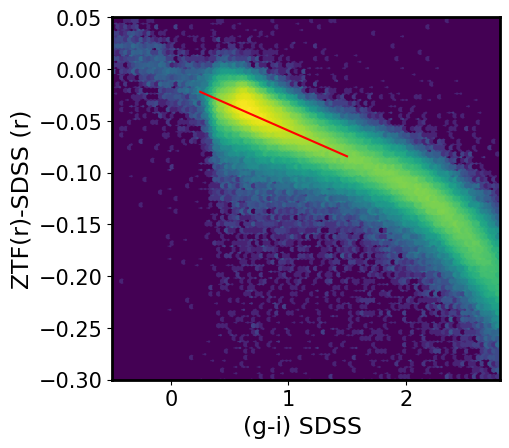

In [100]:
find_offset_sdss_survey(s82_ztf,
                        originband = 'r',
                        targetband = 'r',
                        ylims = [-0.3, 0.05],
                        xlims=[-0.5,2.8],
                        nsources=900000, save=True, rlim=20
                       )

Try fitting a simple polynomial,  just like Thanjavur+2022

/epyc/opt/anaconda/lib/python3.7/site-packages/pyarrow/__init__.py:152: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


 
y = f1 - f2 = f(x)
f2 = f1 - f(x)
Starting with  900000  objects 

Removing objects where nobs_r < 10 
= Left with  870451  objects

Also removing faint objects where SDSS r >20
= Left with  499971 objects

 In total left with 487572


/epyc/opt/anaconda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "



Of these we do not use for fitting those  beyond the limits of the     plot, or xlims of fitted region.
=Left with  469313  objects used for fitting
y = f(x) = A0 + A1*x + A2*x*x
Figure saved as  Offsets_ZTFr-SDSSr_SDSSgi.png
    x          y      ...          A_1                  A_2         
---------- ---------- ... --------------------- --------------------
(g-i)_SDSS rZTF-rSDSS ... -0.013953208019038613 -0.01579283040494562


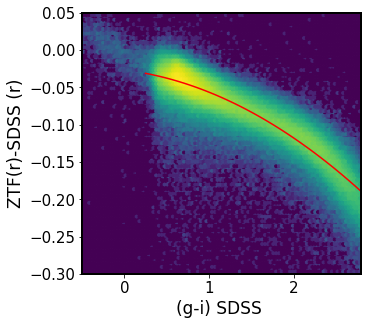

In [49]:
find_offset_sdss_survey(s82_ztf,
                        originband = 'r',
                        targetband = 'r',
                        ylims = [-0.3, 0.05],
                        xlims=[-0.5,2.8],
                        nsources=900000,
                        degree = 2 , 
                        xfitlims = [0.25, 2.8]
                       )

## Show the effect of applying the linear correction

In [ ]:
data = s82_ztf.select(['mean_mag_g', 'mean_mag_r','mean_mag_i',
                       'umed', 'ummu',
       'umsig', 'umrms', 'umchi2', 'gNobs', 'gmed', 'gmmu', 'gmsig',
       'gmrms', 'gmchi2', 'rNobs', 'rmed', 'rmmu', 'rmsig', 'rmrms',
       'rmchi2', 'iNobs', 'imed', 'immu', 'imsig', 'imrms', 'imchi2',
       'zNobs', 'zmed', 'zmmu', 'zmsig', 'zmrms', 'zmchi2']).limit(600000).toPandas()

#data = s82_ztf.select(s82_ztf.columns).limit(1000).toPandas()

magCol  = 'mmu'
gmag = data[f'g{magCol}']
rmag = data[f'r{magCol}']
imag = data[f'i{magCol}']
r_ZTF  = data['mean_mag_r']


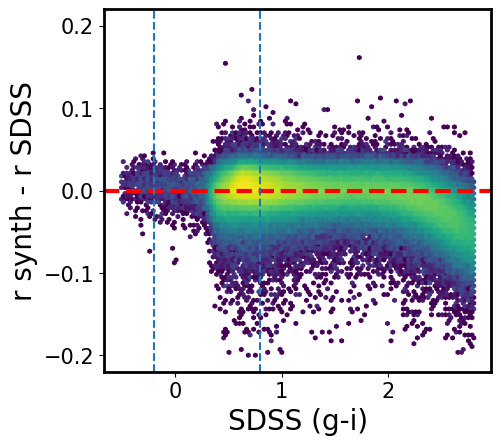

In [101]:
#B0 =  -0.009# offset
#B1 = -0.048 # slope 
B0 = -0.009536170328042621 
B1 = -0.049800524013098306
r_SDSS_synth = r_ZTF - ( B0 )-( B1 )* ( gmag - imag) 

xlims = [-0.5,2.8]
ylims = [-0.2,0.2]
x = gmag-imag
y = r_SDSS_synth-rmag
Nmin = 100
rlim = 20.

m = rmag < rlim

fig,ax = plt.subplots(1,1, figsize=(5, 4.8), dpi=100)
ax.hexbin(x[m],y[m], extent= (xlims[0],xlims[1],ylims[0], ylims[1]), bins='log',
         mincnt=np.log10(Nmin))
ax.set_xlabel('SDSS (g-i)')
ax.set_ylabel('r synth - r SDSS')
ax.axhline(0, ls='--', lw=3,c='r')
ax.axvline(-0.2,ls='--')
ax.axvline(0.8,ls='--',)
plt.savefig('2022_ZTF_rsynth-SDSS_r_vs_SDSS_gi.png', bbox_inches='tight')

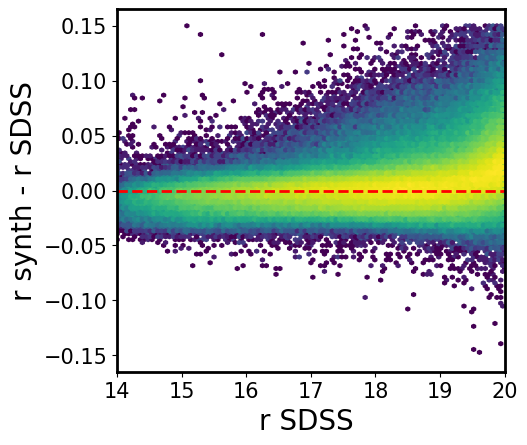

In [104]:

r_SDSS_synth = r_ZTF - ( B0 )-( B1 )* ( gmag - imag) 

xlims = [14,20]
ylims = [-0.15,0.15]
x = rmag
y = rmag-r_SDSS_synth
Nmin = 100
rlim = 20.

m = rmag <rlim

fig,ax = plt.subplots(1,1, figsize=(5, 4.8), dpi=100)
ax.hexbin(x[m],y[m], extent= (xlims[0],xlims[1],ylims[0], ylims[1]), bins='log',
         mincnt=np.log10(Nmin))
ax.set_ylabel('r synth - r SDSS')
ax.set_xlabel('r SDSS ')
ax.set_xlim(xlims)
ax.axhline(0, ls='--', lw=2,c='r')
plt.savefig('2022_ZTF_rsynth-SDSS_r_vs_SDSS_r.png', bbox_inches='tight')
#ax.axvline(-0.2,ls='--')
#ax.axvline(0.8,ls='--',)

## Plot SDSS (g-i) vs SDSS(r) for standard stars 

In [88]:
#axs_catalog.list_table_names()

In [6]:
import matplotlib.pyplot as plt
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

In [4]:
data = s82_ztf.select(['mean_mag_g', 'mean_mag_r','mean_mag_i',
                       'umed', 'ummu',
       'umsig', 'umrms', 'umchi2', 'gNobs', 'gmed', 'gmmu', 'gmsig',
       'gmrms', 'gmchi2', 'rNobs', 'rmed', 'rmmu', 'rmsig', 'rmrms',
       'rmchi2', 'iNobs', 'imed', 'immu', 'imsig', 'imrms', 'imchi2',
       'zNobs', 'zmed', 'zmmu', 'zmsig', 'zmrms', 'zmchi2']).limit(900000).toPandas()

#data = s82_ztf.select(s82_ztf.columns).limit(1000).toPandas()

magCol  = 'mmu'
gmag = data[f'g{magCol}']
rmag = data[f'r{magCol}']
imag = data[f'i{magCol}']

/epyc/opt/anaconda/lib/python3.7/site-packages/pyarrow/__init__.py:152: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


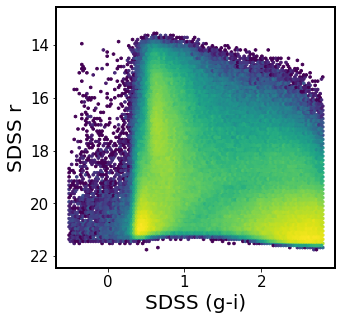

In [59]:
import pandas as pd
import numpy as np
xlims = [-0.5,2.8]
ylims = [13,22]
x = gmag-imag
y = rmag
Nmin = 100
fig,ax = plt.subplots(1,1, figsize=(5, 4.8))
ax.hexbin(x,y, extent= (xlims[0],xlims[1],ylims[0], ylims[1]), bins='log',
         mincnt=np.log10(Nmin))
ax.set_xlabel('SDSS (g-i)')
ax.set_ylabel('SDSS r')
ax.invert_yaxis()

Text(0, 0.5, 'ZTF r')

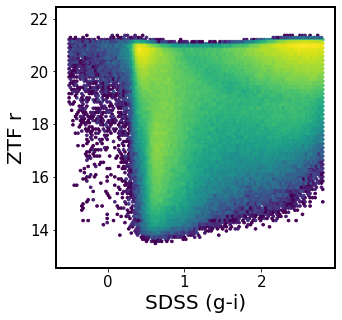

In [9]:
xlims = [-0.5,2.8]
ylims = [13,22]
x = gmag-imag
y = data['mean_mag_r']
fig,ax = plt.subplots(1,1, figsize=(5, 4.8))
ax.hexbin(x,y, extent= (xlims[0],xlims[1],ylims[0], ylims[1]), bins='log', mincnt=np.log10(Nmin))
ax.set_xlabel('SDSS (g-i)')
ax.set_ylabel('ZTF r')

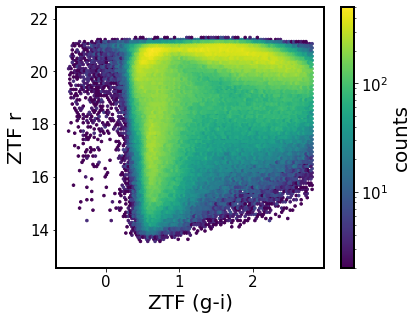

In [10]:
xlims = [-0.5,2.8]
ylims = [13,22]
x = data['mean_mag_g']-data['mean_mag_i']
y = data['mean_mag_r']
fig,ax = plt.subplots(1,1, figsize=(6, 4.8))
mappable = ax.hexbin(x,y, extent= (xlims[0],xlims[1],ylims[0], ylims[1]),
          bins='log',mincnt=np.log10(Nmin))
ax.set_xlabel('ZTF (g-i)')
ax.set_ylabel('ZTF r')
plt.colorbar(mappable, label='counts')

Text(0, 0.5, 'ZTF r - SDSS r ')

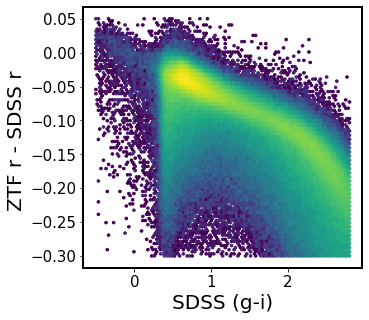

In [12]:
xlims = [-0.5,2.8]
ylims = [-0.3,0.05]
x = gmag-imag
y = data['mean_mag_r']-rmag
fig,ax = plt.subplots(1,1, figsize=(5, 4.8))
ax.hexbin(x,y, extent= (xlims[0],xlims[1],ylims[0], ylims[1]), bins='log',
         mincnt=np.log10(Nmin))
ax.set_xlabel('SDSS (g-i)')
ax.set_ylabel('ZTF r - SDSS r ')

I initially wasn't sure what is the feature around (g-i) ~ 0.5 , but it's only present in faint stars...

Text(0.5, 1.0, 'SDSS g>20')

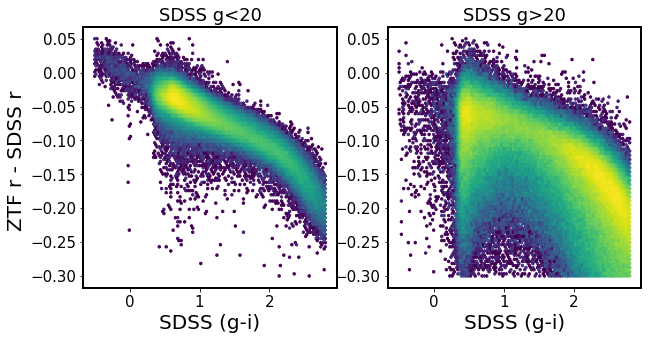

In [34]:
# Try limiting the magnitude range 
xlims = [-0.5,2.8]
ylims = [-0.3,0.05]

glim = 20

# left panel : bright objects
m = gmag<glim
x = gmag - imag
y = data['mean_mag_r'] - rmag
fig,ax = plt.subplots(1,2, figsize=(10, 4.8))
ax[0].hexbin(x[m], y[m], extent= (xlims[0],xlims[1],ylims[0], ylims[1]), bins='log',
         mincnt=np.log10(Nmin))
ax[0].set_xlabel('SDSS (g-i)')
ax[0].set_ylabel('ZTF r - SDSS r ')
ax[0].set_title(f'SDSS g<{glim}')

# right panel: faint objects
m = gmag>glim
x = gmag - imag
y = data['mean_mag_r'] - rmag
ax[1].hexbin(x[m], y[m], extent= (xlims[0],xlims[1],ylims[0], ylims[1]), bins='log',
         mincnt=np.log10(Nmin))
ax[1].set_xlabel('SDSS (g-i)')
#ax[1].set_ylabel('ZTF r - SDSS r ')
ax[1].set_title(f'SDSS g>{glim}')

Similar to Fig.3 from Thanjavur+2022, where gaiaG-SDSSr is plotted also as a function of SDSS(g-i).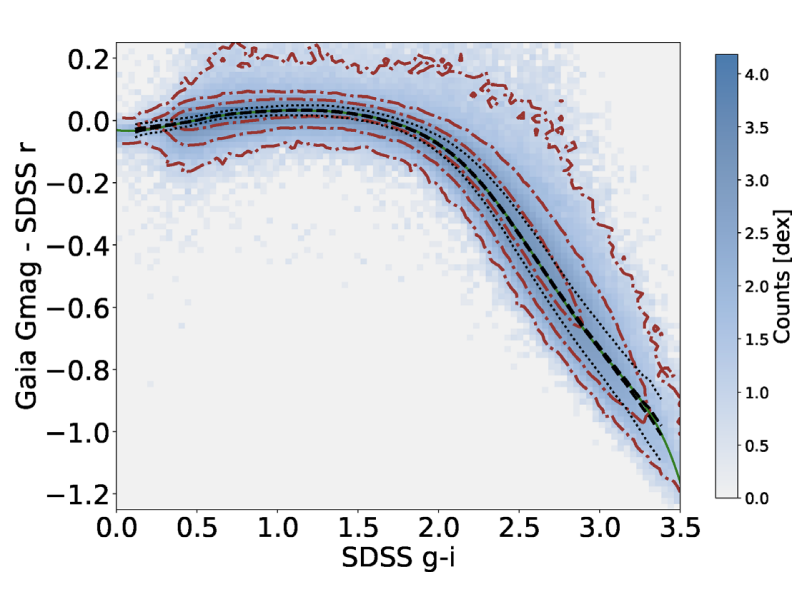  GaiaG is a very broad filter, spanning from 4000 to 8000 A. It centers on  SDSS r and ZTF r . 

Text(0, 0.5, 'SDSS g - SDSS r ')

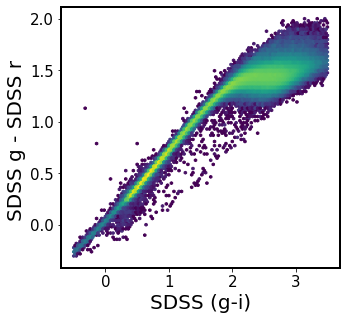

In [19]:
xlims = [-0.5,3.5]
ylims = [-0.3,2]
x = gmag-imag
y = gmag-rmag
fig,ax = plt.subplots(1,1, figsize=(5, 4.8))
ax.hexbin(x,y, extent= (xlims[0],xlims[1],ylims[0], ylims[1]), bins='log',
         mincnt=np.log10(Nmin))
ax.set_xlabel('SDSS (g-i)')
ax.set_ylabel('SDSS g - SDSS r ')

From https://www.astroml.org/book_figures/appendix/fig_sdss_filters.html - plot SDSS filter , and plot ZTF filter too! What's the feature around (g-i) ~ 0.5 ? 

In [3]:
from matplotlib import pyplot as plt
from astroML.datasets import fetch_sdss_filter, fetch_vega_spectrum

In [2]:
!pip install astroML

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 134 kB 3.7 MB/s eta 0:00:01


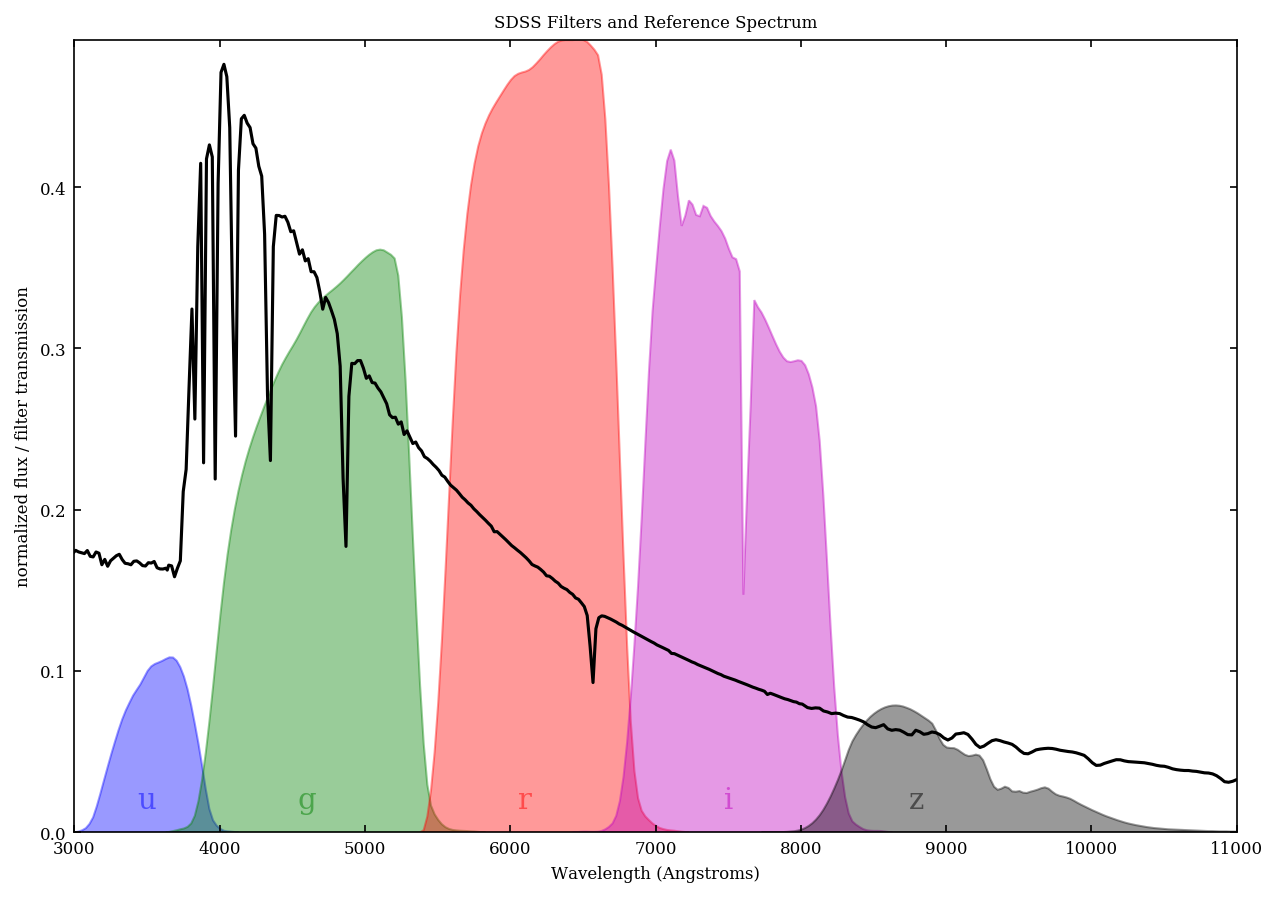

In [6]:
#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Set up figure and axes
fig = plt.figure(figsize=(10, 7), dpi=150)
ax = fig.add_subplot(111)

#----------------------------------------------------------------------
# Fetch and plot the Vega spectrum
spec = fetch_vega_spectrum()
lam = spec[0]
spectrum = spec[1] / 2.1 / spec[1].max()
ax.plot(lam, spectrum, '-k')

#------------------------------------------------------------
# Fetch and plot the five filters
text_kwargs = dict(ha='center', va='center', alpha=0.5, fontsize=14)

for f, c, loc in zip('ugriz', 'bgrmk', [3500, 4600, 6100, 7500, 8800]):
    data = fetch_sdss_filter(f)
    ax.fill(data[0], data[1], ec=c, fc=c, alpha=0.4)
    ax.text(loc, 0.02, f, color=c, **text_kwargs)

ax.set_xlim(3000, 11000)

ax.set_title('SDSS Filters and Reference Spectrum')
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('normalized flux / filter transmission')

plt.show()

This website is useful   , but I couldn't get teh download to work with `wget`. Turned out that their source for ZTF is a github repo https://github.com/ZwickyTransientFacility/ztf_information  that I cloned. So the filter information is:

In [15]:
gpath = 'ztf_information/filter_transmission/ZTF_g_band_test_data_pos1_0AOI.csv'
rpath = 'ztf_information/filter_transmission/ZTF_r_band_test_data_pos1_0AOI.csv'
ipath = 'ztf_information/filter_transmission/ztf_i_band.csv'

In [33]:
from astropy.table import Table
ztf_filters = {}
for fid, fpath in zip('gri', [gpath, rpath, ipath]): 
    ztf_filters[fid] = Table.read(fpath, format='ascii.no_header',
                    names=['lambda', 'transmission'])

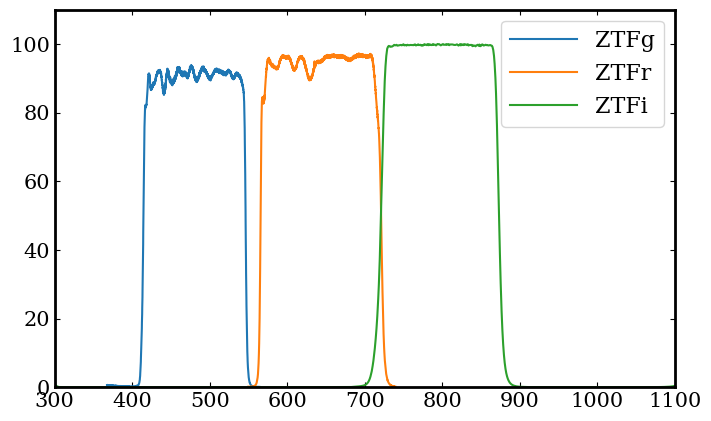

In [40]:
import matplotlib.pyplot as plt
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
fig,ax = plt.subplots(1,1,figsize=(8,5), dpi=100)
for fid in 'gri':
    fdata = ztf_filters[fid]
    ax.plot(fdata['lambda'], fdata['transmission'], label=f'ZTF{fid}')
ax.set_ylim(0,110)
ax.legend(fontsize=16)

Plot ZTF and SDSS r-filters together :

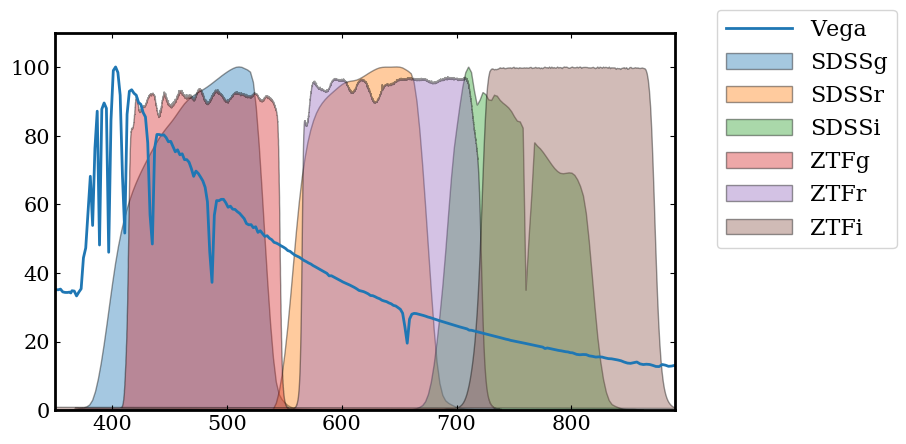

In [167]:

fig,ax = plt.subplots(1,1,figsize=(8,5), dpi=100)
for fid in 'gri':
    data = fetch_sdss_filter(fid)
    f = 100/max(data[1])
    ax.fill(data[0]/10., f*data[1], alpha=0.4, label=f'SDSS{fid}')


for fid in 'gri':
    fdata = ztf_filters[fid]
    y =  fdata['transmission'].data
    ax.fill(fdata['lambda'],y,alpha=0.4,label=f'ZTF{fid}')

f = 100/max(spec[1])
ax.plot(spec[0]/10.,f*spec[1], lw=2, ls='-', label='Vega')
ax.set_xlim(350, 890)
ax.set_ylim(0,110)
plt.legend(fontsize=16,bbox_to_anchor=[1.05,0.4])

Ok, I'm still not sure about the feature at (g-i) of 0.5,  but since it's also present in the simple plot of SDSS(g-i) vs SDSS(r),  it must be inherent to the stellar spectrum, and not due to filter differences. 

In [140]:
y = fdata['transmission'].data
np.sum(y)

76731.84015599999

In [147]:
f = 100/max(data[1])

In [148]:
max(data[1]*f)

100.0